# Gaussian Mixture Model
The univariate Gaussian Mixture Model can be represented:
$$
\begin{align*}
    p(s)   &= \mathrm{Bet}(s|\alpha_s, \beta_s) \\
    p(m_{l}) &=  \mathcal{N}(m_l|\mu_l, \sigma_l) \\    
    p(w_{l}) &=  \Gamma(w_l|\alpha_l, \beta_l) \\
    p(z_i) &=  \mathrm{Ber}(z_i|s) \\
    p(y_i) &= \prod_{l=1}^L \mathcal{N}\left(m_{l}, w_{l}\right)^{z_{i}}
\end{align*}
$$

In [1]:
using Rocket, ReactiveMP, GraphPPL
using Distributions, Random, BenchmarkTools

In [2]:
@model [ default_factorisation = MeanField() ] function gaussian_mixture_model(n)
    
    s ~ Beta(1.0, 1.0)
    
    m1 ~ NormalMeanVariance(-2.0, 1e3)
    w1 ~ GammaShapeRate(0.01, 0.01)
    
    m2 ~ NormalMeanVariance(2.0, 1e3)
    w2 ~ GammaShapeRate(0.01, 0.01)
    
    z = randomvar(n)
    y = datavar(Float64, n)
    
    for i in 1:n
        z[i] ~ Bernoulli(s)
        y[i] ~ NormalMixture(z[i], (m1, m2), (w1, w2))
    end
    
    return s, m1, w1, m2, w2, z, y
end

In [7]:
n = 50

Random.seed!(124)

switch = [ 1/3, 2/3 ]
z      = rand(Categorical(switch), n)
y      = Vector{Float64}(undef, n)

μ1 = -10.0
μ2 = 10.0
w  = 1.777

dists = [
    Normal(μ1, sqrt(inv(w))),
    Normal(μ2, sqrt(inv(w))),
]

for i in 1:n
    y[i] = rand(dists[z[i]])
end

In [8]:
model = Model(gaussian_mixture_model, length(y))
data = (y = y,)
initmarginals = (s = vague(Beta), m1 = NormalMeanVariance(-2.0, 1e3), m2 = NormalMeanVariance(2.0, 1e3), w1 = vague(GammaShapeRate), w2 =vague(GammaShapeRate))

@time result = inference(model=model, data=data, initmarginals=initmarginals, iterations=10, free_energy=true);

  0.006326 seconds (98.42 k allocations: 6.082 MiB)


In [32]:
using Parameters
@unpack s, m1, w1, m2, w2, z = result.posteriors
mswitch, mm1, mw1, mm2, mw2, mz = s, m1, w1, m2, w2, z;
fe = result.free_energy;

In [33]:
using Plots

dim(d) = (a) -> map(r -> r[d], a)

dim (generic function with 1 method)

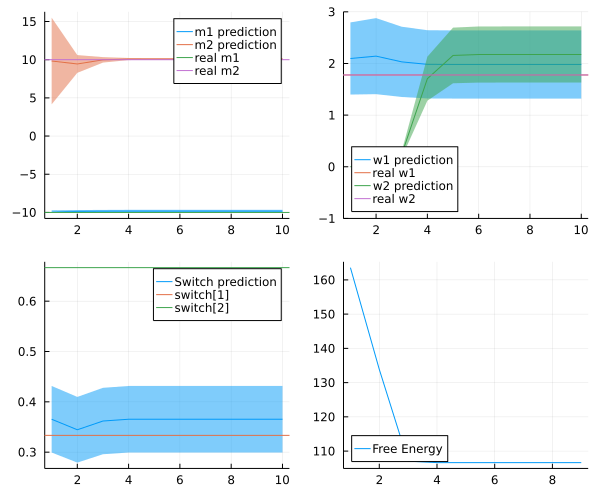

In [34]:
mp = plot(mean.(mm1), ribbon = var.(mm1) .|> sqrt, label = "m1 prediction")
mp = plot!(mean.(mm2), ribbon = var.(mm2) .|> sqrt, label = "m2 prediction")
mp = plot!(mp, [ μ1 ], seriestype = :hline, label = "real m1")
mp = plot!(mp, [ μ2 ], seriestype = :hline, label = "real m2")

wp = plot(mean.(mw1), ribbon = var.(mw1) .|> sqrt, label = "w1 prediction", legend = :bottomleft, ylim = (-1, 3))
wp = plot!(wp, [ w ], seriestype = :hline, label = "real w1")
wp = plot!(wp, mean.(mw2), ribbon = var.(mw2) .|> sqrt, label = "w2 prediction")
wp = plot!(wp, [ w ], seriestype = :hline, label = "real w2")

swp = plot(mean.(mswitch), ribbon = var.(mswitch) .|> sqrt, label = "Switch prediction")

swp = plot!(swp, [ switch[1] ], seriestype = :hline, label = "switch[1]")
swp = plot!(swp, [ switch[2] ], seriestype = :hline, label = "switch[2]")

fep = plot(fe[2:end], label = "Free Energy", legend = :bottomleft)

plot(mp, wp, swp, fep, layout = @layout([ a b; c d ]), size = (600, 500))

In [36]:
@benchmark inference(model=$model, data=$data, initmarginals=$initmarginals, iterations=10, free_energy=true)

BenchmarkTools.Trial: 755 samples with 1 evaluation.
 Range (min … max):  5.399 ms … 22.097 ms  ┊ GC (min … max):  0.00% … 64.54%
 Time  (median):     5.730 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   6.617 ms ±  3.005 ms  ┊ GC (mean ± σ):  12.39% ± 16.90%

  ▇█▆▄▃                                                       
  █████▇▆▇▅▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▇███▇▇ ▇
  5.4 ms       Histogram: log(frequency) by time     17.6 ms <

 Memory estimate: 6.08 MiB, allocs estimate: 98413.